In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# import standard curve data

We executed primer efficiency characterization using:
- MG1655 + Fhr + pTarget (pConst-sfGFP-ssrA) overnight culture 
    
First boiled the overnight culture and serial diluted (10-fold each) to plot standard curves and compute the efficiency of each qPCR primer + probe pairs.

The results show that primers and probes for quantifying pTarget plasmid copy number relative to genome copy number had reasonable efficiencies.
- 108% for genome (targeting the *dxs* gene)
- 97% for pTarget (targeting the *sfGFP* gene)

In [2]:
# import data for standard curve (host cell carrying the target plasmid only)
xl = pd.ExcelFile('FigS13_data_standard_curve.xls')
df = xl.parse('anno_results', header = 46).loc[:288, ['Well Position','Sample Name', 'Log(Dilution rate)', 'rep','Target Name', 'CT']]
std_curv_df = df[df['Sample Name'] == 'pTarget_only_const-ssra']

# reorganize data into a single dataframe
temp_dxs = std_curv_df[std_curv_df['Target Name']=='dxs']
temp_dxs = temp_dxs.rename(columns={'CT':'dxs CT'})

temp_gfp = std_curv_df[std_curv_df['Target Name']=='sfGFP']
temp_gfp = temp_gfp.rename(columns={'CT':'gfp CT'})

temp_merged = pd.merge(temp_dxs, temp_gfp, 
                    on=['Well Position', 'Sample Name',
                         'Log(Dilution rate)', 'rep'])

# replace 'Undetermined' with NaN so that we can plot
replace_undetermined = temp_merged['dxs CT'].replace('Undetermined',np.nan )
temp_merged.insert(6, 'dxs ct for plot', replace_undetermined)

std_curv_merged = temp_merged.copy()
display(std_curv_merged.head())
display(std_curv_merged.tail())

,Well Position,Sample Name,Log(Dilution rate),rep,Target Name_x,dxs CT,dxs ct for plot,Target Name_y,gfp CT
0,A1,pTarget_only_const-ssra,0,1,dxs,19.710043,19.710043,sfGFP,11.846498
1,A2,pTarget_only_const-ssra,0,2,dxs,19.641787,19.641787,sfGFP,11.800009
2,A3,pTarget_only_const-ssra,0,3,dxs,19.658596,19.658596,sfGFP,11.932109
3,A4,pTarget_only_const-ssra,0,4,dxs,19.599806,19.599806,sfGFP,11.984009
4,B1,pTarget_only_const-ssra,-1,1,dxs,22.69684,22.696840,sfGFP,15.7602


,Well Position,Sample Name,Log(Dilution rate),rep,Target Name_x,dxs CT,dxs ct for plot,Target Name_y,gfp CT
27,G4,pTarget_only_const-ssra,-6,4,dxs,37.374451,37.374451,sfGFP,34.007942
28,H1,pTarget_only_const-ssra,-7,1,dxs,Undetermined,NaN,sfGFP,36.423897
29,H2,pTarget_only_const-ssra,-7,2,dxs,Undetermined,NaN,sfGFP,36.207615
30,H3,pTarget_only_const-ssra,-7,3,dxs,Undetermined,NaN,sfGFP,38.115345
31,H4,pTarget_only_const-ssra,-7,4,dxs,Undetermined,NaN,sfGFP,36.519527


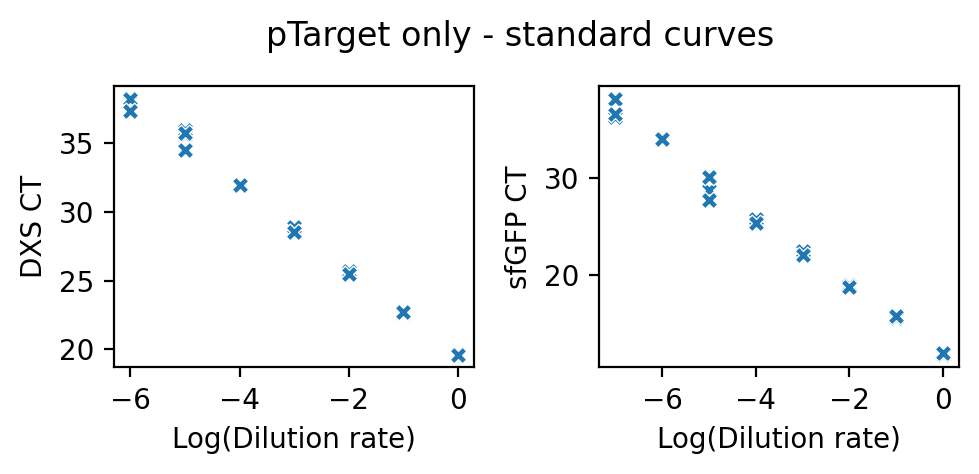

In [3]:
# plot data
fig, axes = plt.subplots(1,2, figsize = (5, 2), dpi = 200)
plt.tight_layout()
sns.scatterplot(std_curv_merged, x = 'Log(Dilution rate)', y = 'dxs ct for plot', ax = axes[0], 
              marker = 'X')
sns.scatterplot(std_curv_merged, x = 'Log(Dilution rate)', y = 'gfp CT', ax = axes[1], 
             marker = 'X')
plt.suptitle('pTarget only - standard curves', va = 'bottom')
axes[0].set_ylabel('DXS CT')
axes[1].set_ylabel('sfGFP CT')
plt.show()

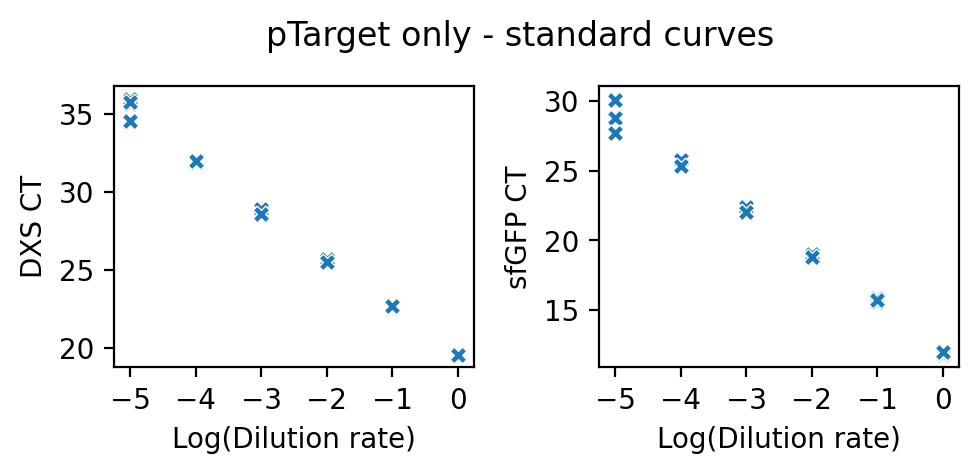

In [4]:
# plot data after truncating data to Log(Dilution rate) > -6 for better fit
fig, axes = plt.subplots(1,2, figsize = (5, 2), dpi = 200)
plt.tight_layout()

idx = std_curv_merged['Log(Dilution rate)']>-6
sns.scatterplot(std_curv_merged[idx], x = 'Log(Dilution rate)', y = 'dxs ct for plot', ax = axes[0], 
              marker = 'X')
sns.scatterplot(std_curv_merged[idx], x = 'Log(Dilution rate)', y = 'gfp CT', ax = axes[1], 
             marker = 'X')
plt.suptitle('pTarget only - standard curves', va = 'bottom')
axes[0].set_ylabel('DXS CT')
axes[1].set_ylabel('sfGFP CT')
axes[0].set_xticks([-5,-4,-3,-2,-1,0])
axes[1].set_xticks([-5,-4,-3,-2,-1,0])
plt.show()

## Equations for calculating the primer efficiency and plasmid copy number:

- First equation adopted from Joshi et al., Nat. Comm. (2022)
- The rest were captured from https://toptipbio.com/primer-efficiency-calculator/

<img src='eq2.png'/>
<img src='efficiency_eq.png'/>

In [5]:
# fit a linear line to calculate slope and intercept
dxs_slope_intercept = np.polyfit(std_curv_merged['Log(Dilution rate)'][idx],std_curv_merged['dxs ct for plot'][idx].astype(float),1)
dxs_slope = dxs_slope_intercept[0]
print('dxs standard curve slope and intercept: ', dxs_slope_intercept)

gfp_slope_intercept = np.polyfit(std_curv_merged['Log(Dilution rate)'][idx],std_curv_merged['gfp CT'][idx].astype(float),1)
gfp_slope = gfp_slope_intercept[0]
print('gfp standard curve slope and intercept: ', gfp_slope_intercept)
print('-----')

# calculate amplification factor
dxs_amp_factor = 10 ** (-1/dxs_slope)
gfp_amp_factor = 10 ** (-1/gfp_slope)

print('dxs amplification factor: ', dxs_amp_factor)
print('gfp amplification factor: ', gfp_amp_factor)
print('-----')

dxs_efficiency = (dxs_amp_factor - 1) * 100
gfp_efficiency = (gfp_amp_factor - 1) * 100

print('dxs primer efficiency: ', f"{dxs_efficiency:.2f}", '%')
print('gfp primer efficiency: ', f"{gfp_efficiency:.2f}", '%')


dxs standard curve slope and intercept:  [-3.14312314 19.4903413 ]
gfp standard curve slope and intercept:  [-3.40688037 12.07184463]
-----
dxs amplification factor:  2.080438544412342
gfp amplification factor:  1.965729074324871
-----
dxs primer efficiency:  108.04 %
gfp primer efficiency:  96.57 %


In [6]:
# calculate plasmid copy number
calculated_pcn = np.zeros(std_curv_merged[idx].shape[0])

for i in np.arange(len(calculated_pcn)):
    numer = dxs_amp_factor**std_curv_merged['dxs ct for plot'].iloc[i]
    denom = gfp_amp_factor**std_curv_merged['gfp CT'].iloc[i]
    calculated_pcn[i] = numer/denom

calculated_pcn

array([621.75454129, 610.30748593, 565.09596133, 522.61751428,
       393.65818322, 413.51095554, 351.202214  , 390.94202514,
       410.97189132, 426.70102821, 397.70264394, 400.27313887,
       350.48089711, 407.93604874, 402.81679873, 408.40344688,
       484.69797916, 518.44165968, 402.47390829, 530.4964395 ,
       779.26915895, 378.38481927, 685.75431294, 339.13632663])

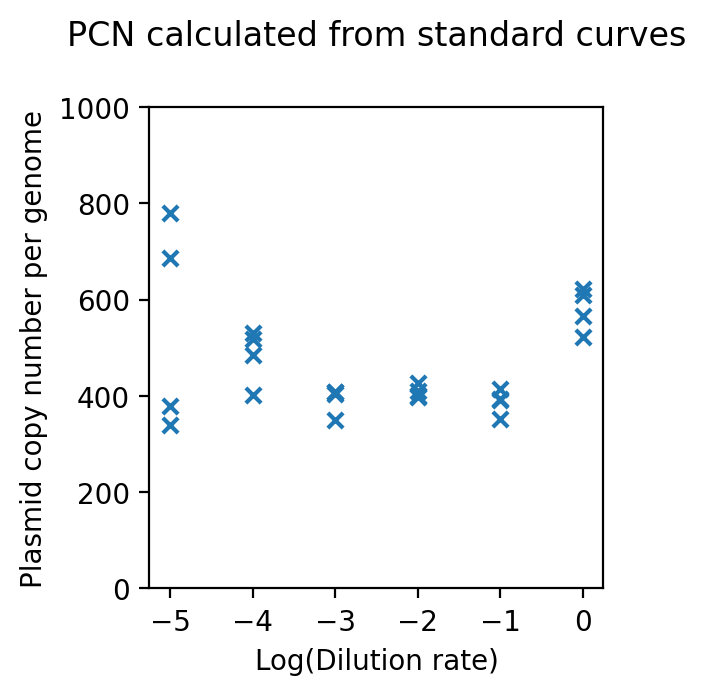

In [7]:
fig, axes = plt.subplots(1,1, figsize = (3, 3), dpi = 200)
plt.tight_layout()
axes.scatter(std_curv_merged['Log(Dilution rate)'][idx], calculated_pcn,
            marker = 'x', s = 30)
axes.set_ylim([0, 1000])
axes.set_xticks([-5,-4,-3,-2,-1,0])
axes.set_xlabel('Log(Dilution rate)')
axes.set_ylabel('Plasmid copy number per genome')
axes.set_title('PCN calculated from standard curves\n',
          va = 'bottom')
plt.show()

# import data for full construct 

- Here, the data was generated using:
    * MG1655 + Fhr + pCas9 + pTarget (pConst-sfGFP-ssrA)

- Overnight culture was 1/100-fold diluted in 10 mL LB + 25 ug/mL Cm
- The diluted cultures were incubated at 37 C (225 rpm) for 3 hours
- After 3 hours, the cells diluted 1/10-fold (10 mL culture + 90 mL fresh LB + cm)
- The diluted culture was distributed in 24 types of media (varying ATc, Kan, and Lin)
    * Using a 96-well deepwell plate
    * 1 mL per well 
    * 4 technical replicate for each sample
- The deepwell plate was incubated at 37 C (700 rpm) for another 3 hours 
- The samples were harvested for 3 types of measurements:
    * Plasmid-carrying fraction measurement via selective plating (Figure 2D)
    * GFP measurements via platereader (Figure 2E)
    * Plasmid copy number measurement via qPCR (Figure 2F)

- Here, this notebook is showing the analysis of the plasmid copy number measurement

In [8]:
# import data
xl = pd.ExcelFile('Fig2F_data_full_construct.xls')
df = xl.parse('anno_results', header = 46).loc[:288, ['Well Position', 'ATc', 'Kan', 'Lin', 'rep','Target Name', 'CT']]

# create separate dataframes for dxs and gfp
dxs_df = df[df['Target Name']=='dxs']
dxs_df = dxs_df.reset_index(drop=True)

gfp_df = df[df['Target Name']=='sfGFP']
gfp_df = gfp_df.reset_index(drop=True)

## combine all info in a single df 
merged_df = pd.merge(dxs_df, gfp_df, on = ['Well Position', 'ATc', 'Kan', 'Lin', 'rep'])
merged_df = merged_df.rename({'CT_x': 'dxs CT', 'CT_y': 'gfp CT'}, axis =1)
display(merged_df)

,Well Position,ATc,Kan,Lin,rep,Target Name_x,dxs CT,Target Name_y,gfp CT
0,A1,0.00,0,0.0,1,dxs,22.600533,sfGFP,20.640169
1,A2,0.01,0,0.0,1,dxs,22.579214,sfGFP,20.623976
2,A3,0.10,0,0.0,1,dxs,22.631758,sfGFP,21.333729
3,A4,1.00,0,0.0,1,dxs,22.536665,sfGFP,23.094667
4,A5,10.00,0,0.0,1,dxs,22.623371,sfGFP,23.123037
...,...,...,...,...,...,...,...,...,...
91,H8,0.01,50,3.2,4,dxs,21.140450,sfGFP,18.799889
92,H9,0.10,50,3.2,4,dxs,21.049458,sfGFP,18.784605
93,H10,1.00,50,3.2,4,dxs,20.789438,sfGFP,20.752605
94,H11,10.00,50,3.2,4,dxs,20.822067,sfGFP,20.735941


In [9]:
## calculate plasmid copy number using the equation above and insert into the combined dataframe
pcn_array = np.zeros(merged_df.shape[0])
for i in np.arange(len(pcn_array)):
    pcn_array[i] = dxs_amp_factor**merged_df.iloc[i]['dxs CT'] / gfp_amp_factor**merged_df.iloc[i]['gfp CT']
merged_df.insert(merged_df.shape[1], 'PCN', pcn_array)
merged_df.head()

,Well Position,ATc,Kan,Lin,rep,Target Name_x,dxs CT,Target Name_y,gfp CT,PCN
0,A1,0.00,0,0.0,1,dxs,22.600533,sfGFP,20.640169,13.554764
1,A2,0.01,0,0.0,1,dxs,22.579214,sfGFP,20.623976,13.491571
2,A3,0.10,0,0.0,1,dxs,22.631758,sfGFP,21.333729,8.678611
3,A4,1.00,0,0.0,1,dxs,22.536665,sfGFP,23.094667,2.462175
4,A5,10.00,0,0.0,1,dxs,22.623371,sfGFP,23.123037,2.573817


In [10]:
## create a new column for ATc concentrations where 0 is replaced by 0.001 for plotting purposes
atc_for_log = merged_df['ATc'].replace(0, 0.001)
merged_df.insert(2, 'ATc for log', atc_for_log)  
merged_df.head()

,Well Position,ATc,ATc for log,Kan,Lin,rep,Target Name_x,dxs CT,Target Name_y,gfp CT,PCN
0,A1,0.00,0.001,0,0.0,1,dxs,22.600533,sfGFP,20.640169,13.554764
1,A2,0.01,0.010,0,0.0,1,dxs,22.579214,sfGFP,20.623976,13.491571
2,A3,0.10,0.100,0,0.0,1,dxs,22.631758,sfGFP,21.333729,8.678611
3,A4,1.00,1.000,0,0.0,1,dxs,22.536665,sfGFP,23.094667,2.462175
4,A5,10.00,10.000,0,0.0,1,dxs,22.623371,sfGFP,23.123037,2.573817


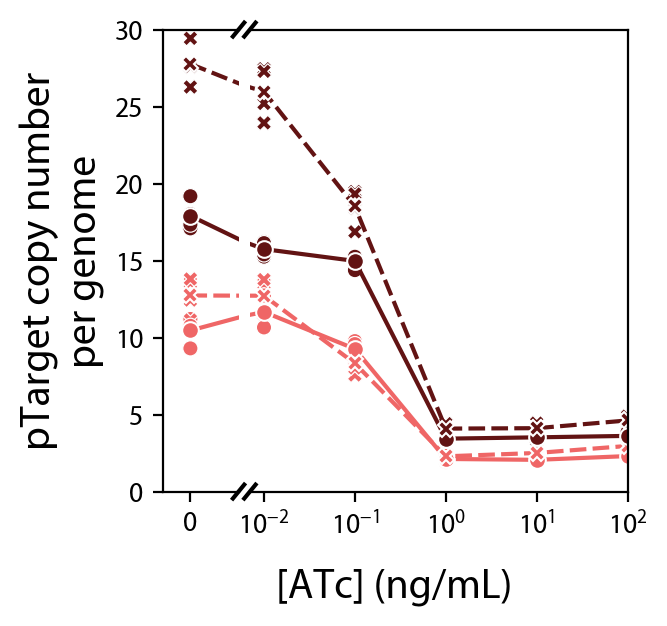

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(3, 3), sharey = False, dpi = 200, width_ratios=[1, 5])
plt.subplots_adjust(
                    wspace=0.05, 
                    )
plt.rcParams['font.sans-serif'] = "Myriad Pro"


sns.lineplot(data = merged_df, x = 'ATc for log', y = 'PCN', hue = 'Kan', style = 'Lin',
             style_order = [3.2, 0], palette=['#EF6666', '#621313'], markers = ['o', 'X'],
             ax = axes[0], errorbar = None)

sns.lineplot(data = merged_df, x = 'ATc for log', y = 'PCN', hue = 'Kan', style = 'Lin',
             style_order = [3.2, 0],palette=['#EF6666', '#621313'], markers = ['o', 'X'],
             ax = axes[1], errorbar = None)

sns.scatterplot(data = merged_df, x = 'ATc for log', y = 'PCN', hue = 'Kan', style = 'Lin',
             style_order = [3.2, 0], palette=['#EF6666', '#621313'], markers = ['o', 'X'],
             ax = axes[0], s = 30, color = ".2")

sns.scatterplot(data = merged_df, x = 'ATc for log', y = 'PCN', hue = 'Kan', style = 'Lin',
             style_order = [3.2, 0],palette=['#EF6666', '#621313'], markers = ['o', 'X'],
             ax = axes[1], s = 30, color = ".2")


axes[0].get_legend().remove()
axes[1].get_legend().remove()

axes[0].set_xlim([0.0004, 0.005])
axes[1].set_xlim([0.007, 101])

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[0].set_xticks([0.001])
axes[0].set_xticklabels(['0'])
axes[0].minorticks_off()

axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].set_yticks([])
axes[1].set_ylabel('')

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=axes[0].transAxes, color='k', clip_on=False)
axes[0].plot((1-5*d, 1+5*d), (-d, +d), **kwargs)
axes[0].plot((1-5*d, 1+5*d), (1-d, 1+d), **kwargs)

kwargs.update(transform=axes[1].transAxes)  # switch to the bottom axes
axes[1].plot((-d, +d), (1-d, 1+d), **kwargs)
axes[1].plot((-d, +d), (-d, +d), **kwargs)

axes[0].set_ylabel('')
axes[1].set_ylabel('')

axes[0].set_ylabel('pTarget copy number\nper genome', fontsize = 15)
axes[0].set_xlabel('')
axes[1].set_xlabel('[ATc] (ng/mL)          ', fontsize = 15,  labelpad = 10, ha='center')

axes[0].set_ylim([0, 30])
axes[1].set_ylim([0, 30])
axes[1].set_xticks([1e-2, 1e-1, 1e0, 1e1, 1e2])

plt.show()